In [10]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_error, precision_score, recall_score, r2_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import optuna

from joblib import Parallel, delayed

# Регрессия

In [11]:
RAW_FEATS = 'regression_raw_feats.csv'
RAW_TARGET = 'regression_raw_target.csv'
PROCESSED_FEATS = 'regression_processed_feats.csv'
PROCESSED_TARGET = 'regression_processed_target.csv'

In [12]:
df_feats_raw = pd.read_csv(RAW_FEATS)
df_target_raw = pd.read_csv(RAW_TARGET)
df_feats_processed = pd.read_csv(PROCESSED_FEATS)
df_target_processed = pd.read_csv(PROCESSED_TARGET)

In [13]:
def evaluate(metrics, y_test, y_pred, round_num):
    for metric in metrics:
        print(f'Model score for metric "{metric.__name__}": {round(metric(y_test, y_pred), round_num)}')

    plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
    line_coords = np.linspace(np.min(y_test), np.max(y_test), 100)
    plt.plot(line_coords, line_coords, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title('Actual vs predicted values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
eval_metrics = [mean_absolute_error, root_mean_squared_error, r2_score]
random_state = 42
test_size = 0.2

round_num = 4

optuna_metric = root_mean_squared_error
optuna_direction = "minimize"
n_trials = 50
cv = 3

## Готовая модель

In [15]:
model_class = GradientBoostingRegressor

### Бейзлайн

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [17]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [19]:
model = model_class(random_state = random_state)

model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [20]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.3449
Model score for metric "root_mean_squared_error": 4.4812
Model score for metric "r2_score": 0.5416


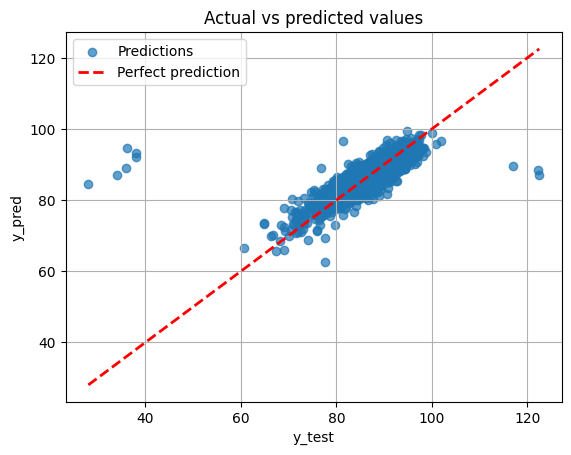

In [21]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [23]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [24]:
model = model_class(random_state = random_state)

model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [25]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.1647
Model score for metric "root_mean_squared_error": 3.1593
Model score for metric "r2_score": 0.6874


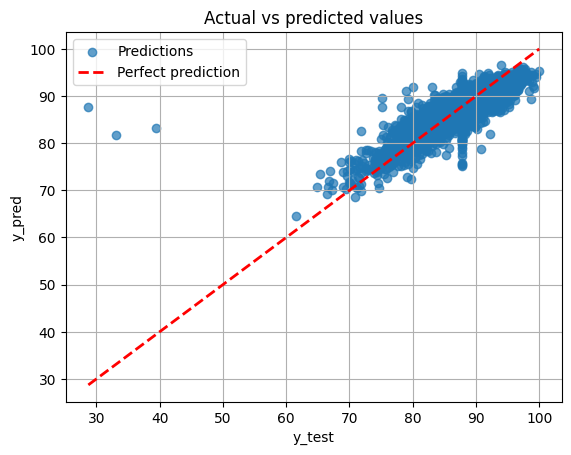

In [26]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [ ]:
def objective(trial):
    optuna_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error']),

        'validation_fraction': trial.suggest_categorical('validation_fraction', [0.2]),
        'n_iter_no_change': trial.suggest_categorical('n_iter_no_change', [10]),
        'tol': trial.suggest_categorical('tol', [1e-4]),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-11 15:17:36,540] A new study created in memory with name: no-name-1696e027-be75-4066-944b-9a0b9931465d
[I 2025-12-11 15:17:40,890] Trial 0 finished with value: 4.448382206448417 and parameters: {'n_estimators': 218, 'learning_rate': 0.1540359659501924, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 4, 'subsample': 0.5779972601681014, 'max_features': 'log2', 'loss': 'huber', 'validation_fraction': 0.2, 'n_iter_no_change': 10, 'tol': 0.0001, 'random_state': 42}. Best is trial 0 with value: 4.448382206448417.
[I 2025-12-11 15:17:45,936] Trial 1 finished with value: 4.79211474045007 and parameters: {'n_estimators': 425, 'learning_rate': 0.0030803400529839683, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.762378215816119, 'max_features': None, 'loss': 'huber', 'validation_fraction': 0.2, 'n_iter_no_change': 10, 'tol': 0.0001, 'random_state': 42}. Best is trial 0 with value: 4.448382206448417.
[I 2025-12-11 15:17:46,828] Trial 2 finish

Лучшие параметры для модели: {'n_estimators': 391, 'learning_rate': 0.024042684781156565, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.5634668012615414, 'max_features': 'sqrt', 'loss': 'huber', 'validation_fraction': 0.2, 'n_iter_no_change': 10, 'tol': 0.0001, 'random_state': 42}
Лучшая метрика (root_mean_squared_error): 4.3212


GradientBoostingRegressor(learning_rate=0.024042684781156565, loss='huber',
                          max_depth=4, max_features='sqrt', min_samples_leaf=3,
                          min_samples_split=3, n_estimators=391,
                          n_iter_no_change=10, random_state=42,
                          subsample=0.5634668012615414,
                          validation_fraction=0.2)

In [29]:
y_pred = best_model.predict(X_test)

Model score for metric "mean_absolute_error": 2.0712
Model score for metric "root_mean_squared_error": 3.0968
Model score for metric "r2_score": 0.6996


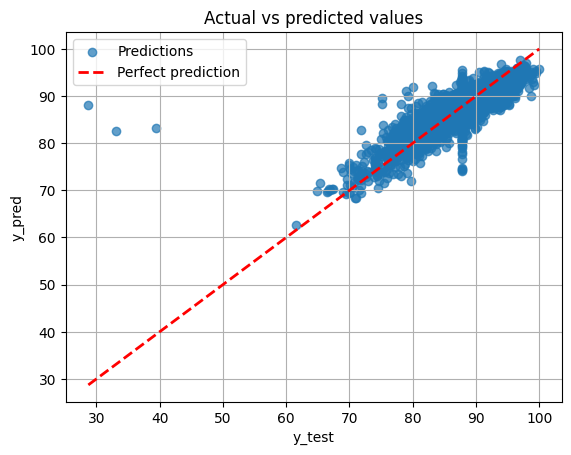

In [30]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

## Своя модель

In [ ]:
class MyGradientBoostingRegressor:
    """
    Parameters
    -----------
    n_estimators : int, default=100
    learning_rate : float, default=0.1
    max_depth : int, default=3
    min_samples_split : int, default=2
    min_samples_leaf : int, default=1
    subsample : float, default=1.0
    max_features : int, float or None, default=None
    loss : {'squared_error', 'absolute_error'}, default='squared_error'
    validation_fraction : float, default=0.1
    n_iter_no_change : int, default=None
    tol : float, default=1e-4
    random_state : int, default=None
    """

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 min_samples_split=2, min_samples_leaf=1, subsample=1.0, 
                 max_features=None, loss='squared_error', validation_fraction=0.1, 
                 n_iter_no_change=None, tol=1e-4, random_state=None):

        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample
        self.max_features = max_features
        self.loss = loss
        self.validation_fraction = validation_fraction
        self.n_iter_no_change = n_iter_no_change
        self.tol = tol
        self.random_state = random_state

        self.estimators_ = []
        self.init_ = None
        self.rng_ = None
        self.n_features_ = None
        self.n_estimators_ = 0

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples.")
            
        self.n_features_ = X.shape[1]
        self.rng_ = np.random.default_rng(self.random_state)
        
        self.init_ = np.mean(y)
        y_pred = np.full(y.shape, self.init_)

        X_train, X_val, y_train, y_val = None, None, None, None
        if self.n_iter_no_change is not None:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=self.validation_fraction, random_state=self.random_state
            )
            self.init_ = np.mean(y_train)
            y_pred_train = np.full(y_train.shape, self.init_)
            y_pred_val = np.full(y_val.shape, self.init_)
        else:
            X_train, y_train, y_pred_train = X, y, y_pred

        best_val_score = np.inf
        no_change_counter = 0

        for i in range(self.n_estimators):
            if self.loss == 'squared_error':
                residual = y_train - y_pred_train
            elif self.loss == 'absolute_error':
                residual = np.sign(y_train - y_pred_train)

            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=self.random_state
            )
            
            if self.subsample < 1.0:
                n_samples = X_train.shape[0]
                sample_indices = self.rng_.choice(
                    n_samples, size=int(self.subsample * n_samples), replace=False
                )
                X_subset, residual_subset = X_train[sample_indices], residual[sample_indices]
            else:
                X_subset, residual_subset = X_train, residual

            tree.fit(X_subset, residual_subset)
            self.estimators_.append(tree)

            update = self.learning_rate * tree.predict(X_train)
            y_pred_train += update

            if self.n_iter_no_change is not None:
                y_pred_val += self.learning_rate * tree.predict(X_val)
                current_val_score = np.mean((y_val - y_pred_val) ** 2)
                
                if current_val_score < (best_val_score - self.tol):
                    best_val_score = current_val_score
                    no_change_counter = 0
                else:
                    no_change_counter += 1
                
                if no_change_counter >= self.n_iter_no_change:
                    self.n_estimators_ = i + 1
                    break
        
        if self.n_estimators_ == 0:
            self.n_estimators_ = self.n_estimators

        return self

    def predict(self, X):
        if not self.estimators_:
            raise RuntimeError("You must call fit() before predict().")

        X = np.asarray(X)

        y_pred = np.full(X.shape[0], self.init_)
        
        for tree in self.estimators_:
            y_pred += self.learning_rate * tree.predict(X)
            
        return y_pred

    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'learning_rate': self.learning_rate,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'subsample': self.subsample,
            'max_features': self.max_features,
            'loss': self.loss,
            'validation_fraction': self.validation_fraction,
            'n_iter_no_change': self.n_iter_no_change,
            'tol': self.tol,
            'random_state': self.random_state,
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter {key} for MyGradientBoostingRegressor")
        return self

In [69]:
model_class = MyGradientBoostingRegressor

### Бейзлайн

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [34]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [36]:
model = model_class(random_state = random_state)

model.fit(X_train, y_train)

In [37]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.344
Model score for metric "root_mean_squared_error": 4.4796
Model score for metric "r2_score": 0.5419


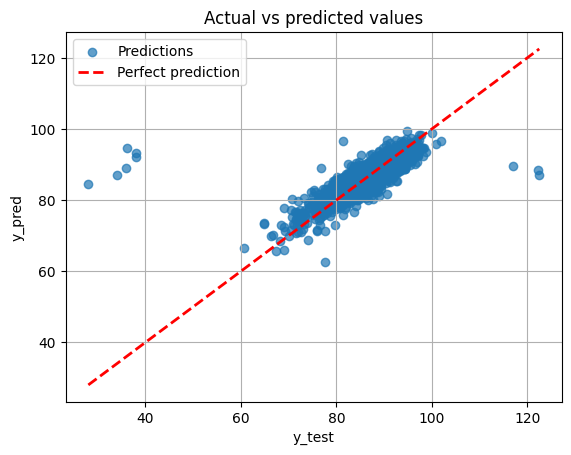

In [38]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Результаты сильно хуже, чем у библиотечной модели.

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [40]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [42]:
model = model_class(random_state = random_state)

model.fit(X_train, y_train)

In [43]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.1623
Model score for metric "root_mean_squared_error": 3.153
Model score for metric "r2_score": 0.6886


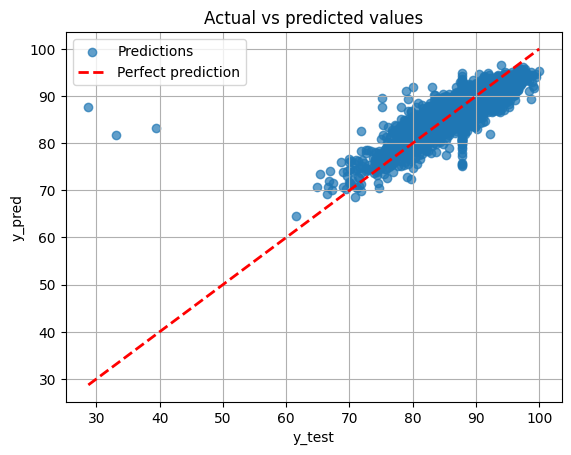

In [44]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Результаты сильно хуже, чем у библиотечной модели.

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [ ]:
def objective(trial):
    optuna_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error']),

        'validation_fraction': trial.suggest_categorical('validation_fraction', [0.1, 0.2]),
        'n_iter_no_change': trial.suggest_categorical('n_iter_no_change', [10, None]),
        'tol': trial.suggest_categorical('tol', [1e-4]),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-11 15:55:11,708] A new study created in memory with name: no-name-c9971b0b-c1c9-4931-b370-34c61d8f272e
[I 2025-12-11 15:55:12,799] Trial 0 finished with value: 4.543937388283859 and parameters: {'n_estimators': 218, 'learning_rate': 0.19014778985134226, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 4, 'subsample': 0.5779972601681014, 'max_features': 'log2', 'loss': 'squared_error', 'validation_fraction': 0.2, 'n_iter_no_change': 10, 'tol': 0.0001, 'random_state': 42}. Best is trial 0 with value: 4.543937388283859.
[I 2025-12-11 15:55:13,064] Trial 1 finished with value: 4.429598062352746 and parameters: {'n_estimators': 487, 'learning_rate': 0.1665052838960043, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.6521211214797689, 'max_features': 'sqrt', 'loss': 'squared_error', 'validation_fraction': 0.2, 'n_iter_no_change': 10, 'tol': 0.0001, 'random_state': 42}. Best is trial 1 with value: 4.429598062352746.
[I 2025-12-11 15:55:13,9

Лучшие параметры для модели: {'n_estimators': 293, 'learning_rate': 0.1082653806047068, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 20, 'subsample': 0.993793954681792, 'max_features': None, 'loss': 'absolute_error', 'validation_fraction': 0.2, 'n_iter_no_change': 10, 'tol': 0.0001, 'random_state': 42}
Лучшая метрика (root_mean_squared_error): 4.3551


In [71]:
y_pred = best_model.predict(X_test)

Model score for metric "mean_absolute_error": 2.1256
Model score for metric "root_mean_squared_error": 3.1403
Model score for metric "r2_score": 0.6911


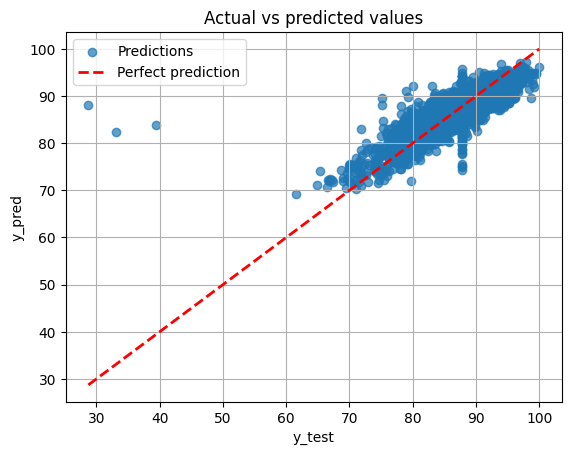

In [72]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Результаты незначительно хуже чем у библиотечной модели, на сотые.

# Классификация

In [73]:
RAW_FEATS = 'classification_raw_feats.csv'
RAW_TARGET = 'classification_raw_target.csv'
PROCESSED_FEATS = 'classification_processed_feats.csv'
PROCESSED_TARGET = 'classification_processed_target.csv'

In [74]:
df_feats_raw = pd.read_csv(RAW_FEATS)
df_target_raw = pd.read_csv(RAW_TARGET)
df_feats_processed = pd.read_csv(PROCESSED_FEATS)
df_target_processed = pd.read_csv(PROCESSED_TARGET)

In [75]:
def evaluate(y_test, y_pred_class, y_pred_proba, round_num):

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

    print(f"ROC AUC: {round(roc_auc,round_num)}", '\n')

    f1 = f1_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)

    print(f"Precision: {round(precision,round_num)}")
    print(f"Recall: {round(recall,round_num)}")
    print(f"F1-Score: {round(f1,round_num)}")

    plt.plot(fpr, tpr, label=f'ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt = 'd', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion matrix')
    plt.show()

In [84]:
eval_metrics = [f1_score, roc_auc_score]
random_state = 42
test_size = 0.2

round_num = 4

optuna_metric = f1_score
optuna_direction = "maximize"
n_trials = 30
cv = 3

max_depth = 5

## Готовая модель

In [77]:
model_class = GradientBoostingClassifier

### Бейзлайн

In [78]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [79]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [81]:
model = model_class(max_depth = max_depth, random_state = random_state)

model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, random_state=42)

In [82]:
y_pred_class = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9727 

Precision: 0.8423
Recall: 0.7075
F1-Score: 0.769


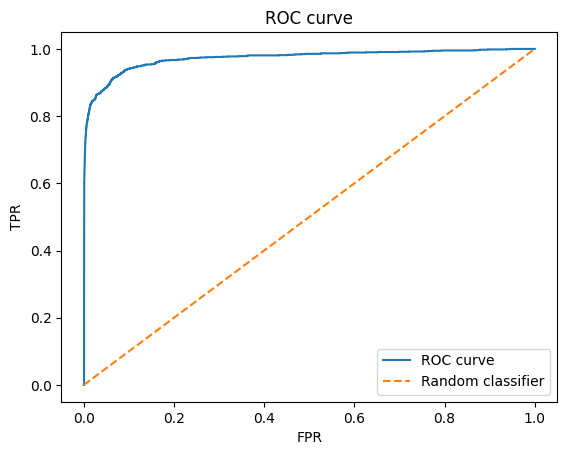

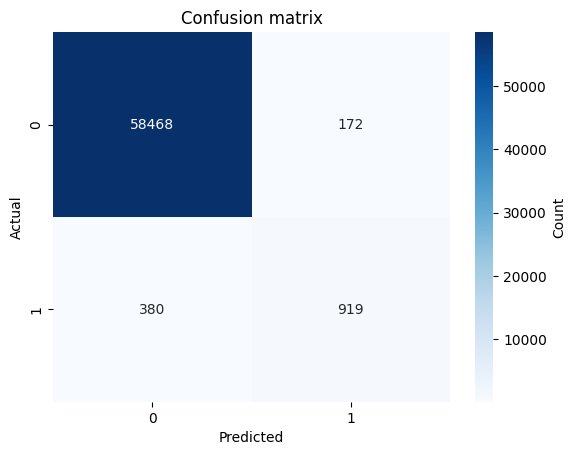

In [83]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [86]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [88]:
model = model_class(max_depth = max_depth, random_state = random_state)

model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=42)

In [89]:
y_pred_class = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9799 

Precision: 0.951
Recall: 0.7621
F1-Score: 0.8462


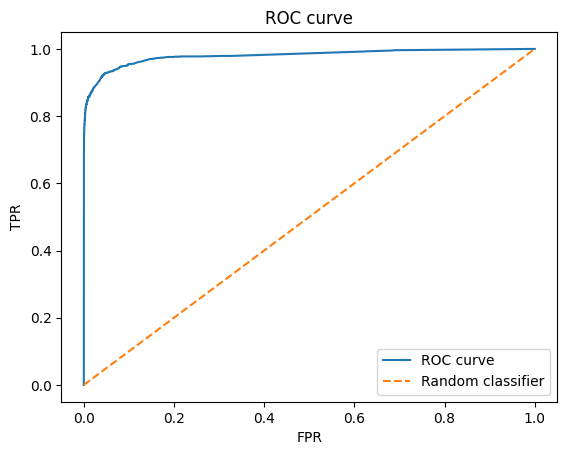

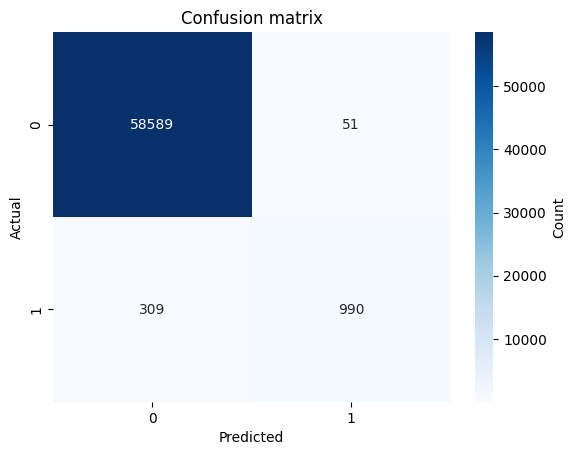

In [90]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [92]:
def objective(trial):
    optuna_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),

        'validation_fraction': trial.suggest_categorical('validation_fraction', [0.2]),
        'n_iter_no_change': trial.suggest_categorical('n_iter_no_change', [10]),
        'tol': trial.suggest_categorical('tol', [1e-4]),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-11 18:24:04,542] A new study created in memory with name: no-name-8e44e27e-b650-4e73-bc13-f23699a6fc0d
[I 2025-12-11 18:24:09,584] Trial 0 finished with value: 0.7963001443506622 and parameters: {'n_estimators': 218, 'learning_rate': 0.19014778985134226, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 4, 'subsample': 0.5779972601681014, 'max_features': 'log2', 'loss': 'log_loss', 'validation_fraction': 0.2, 'n_iter_no_change': 10, 'tol': 0.0001, 'random_state': 42}. Best is trial 0 with value: 0.7963001443506622.
[I 2025-12-11 18:24:17,176] Trial 1 finished with value: 0.8224634205355225 and parameters: {'n_estimators': 487, 'learning_rate': 0.1665052838960043, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.6521211214797689, 'max_features': 'sqrt', 'loss': 'log_loss', 'validation_fraction': 0.2, 'n_iter_no_change': 10, 'tol': 0.0001, 'random_state': 42}. Best is trial 1 with value: 0.8224634205355225.
[W 2025-12-11 18:24:42,890] Tr

KeyboardInterrupt: 

In [51]:
y_pred_class = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

ROC AUC: 0.9786 

Precision: 0.9507
Recall: 0.7567
F1-Score: 0.8427


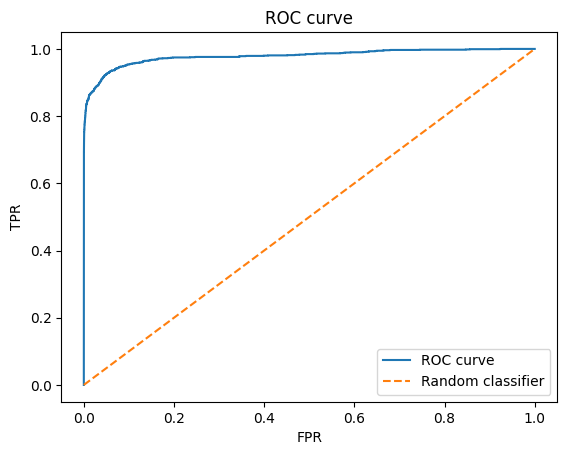

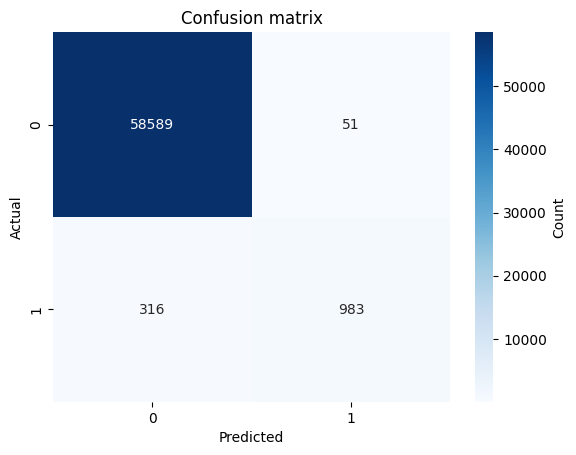

In [52]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

## Своя модель

In [147]:

class MyGradientBoostingClassifier:
    """
    Parameters
    -----------
    n_estimators : int, default=100
    learning_rate : float, default=0.1
    max_depth : int, default=3
    min_samples_split : int, default=2
    min_samples_leaf : int, default=1
    subsample : float, default=1.0
    max_features : int, float, str or None, default=None
    loss : {'log_loss', 'exponential'}, default='log_loss'
    validation_fraction : float, default=0.1
    n_iter_no_change : int, default=None
    tol : float, default=1e-4
    random_state : int, default=None
    """

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 min_samples_split=2, min_samples_leaf=1, subsample=1.0, 
                 max_features=None, loss='log_loss', validation_fraction=0.1, 
                 n_iter_no_change=None, tol=1e-4, random_state=None):

        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample
        self.max_features = max_features
        self.loss = loss
        self.validation_fraction = validation_fraction
        self.n_iter_no_change = n_iter_no_change
        self.tol = tol
        self.random_state = random_state

        self.estimators_ = []
        self.init_ = None
        self.classes_ = None
        self.n_classes_ = None
        self.rng_ = None
        self.n_features_ = None
        self.n_estimators_ = 0

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples.")

        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        y_encoded = y

        self.n_features_ = X.shape[1]
        self.rng_ = np.random.default_rng(self.random_state)
        
        p = np.mean(y_encoded)

        p = np.clip(p, 1e-15, 1 - 1e-15)
        self.init_ = np.log(p / (1 - p))

        X_train, X_val, y_train_encoded, y_val_encoded = None, None, None, None
        if self.n_iter_no_change is not None:
            X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(
                X, y_encoded, test_size=self.validation_fraction, random_state=self.random_state, stratify=y_encoded
            )
            p_train = np.mean(y_train_encoded)
            p_train = np.clip(p_train, 1e-15, 1 - 1e-15)
            self.init_ = np.log(p_train / (1 - p_train))
        else:
            X_train, y_train_encoded = X, y_encoded
        
        y_pred_train = np.full(y_train_encoded.shape, self.init_)

        best_val_score = np.inf
        no_change_counter = 0


        for i in range(self.n_estimators):

            probas = 1 / (1 + np.exp(-y_pred_train))
            probas = np.clip(probas, 1e-15, 1 - 1e-15)
            
            if self.loss == 'log_loss':
                residual = y_train_encoded - probas
            elif self.loss == 'exponential':
                residual = y_train_encoded * np.exp(-y_train_encoded * y_pred_train)

            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=self.random_state
            )
            
            if self.subsample < 1.0:
                n_samples = X_train.shape[0]
                sample_indices = self.rng_.choice(
                    n_samples, size=int(self.subsample * n_samples), replace=False
                )
                X_subset, residual_subset = X_train[sample_indices], residual[sample_indices]
            else:
                X_subset, residual_subset = X_train, residual

            tree.fit(X_subset, residual_subset)
            self.estimators_.append(tree)

            update = self.learning_rate * tree.predict(X_train)
            y_pred_train += update

            if self.n_iter_no_change is not None:
                y_pred_val = np.full(y_val_encoded.shape, self.init_)
                for estimator in self.estimators_:
                    y_pred_val += self.learning_rate * estimator.predict(X_val)
                
                val_probas = 1 / (1 + np.exp(-y_pred_val))
                val_probas = np.clip(val_probas, 1e-15, 1 - 1e-15)
                current_val_score = -np.mean(y_val_encoded * np.log(val_probas) + (1 - y_val_encoded) * np.log(1 - val_probas))
                
                if current_val_score < (best_val_score - self.tol):
                    best_val_score = current_val_score
                    no_change_counter = 0
                else:
                    no_change_counter += 1
                
                if no_change_counter >= self.n_iter_no_change:
                    self.n_estimators_ = i + 1
                    break
        
        if self.n_estimators_ == 0:
            self.n_estimators_ = self.n_estimators

        return self

    def _predict_raw_scores(self, X):
        if not self.estimators_:
            raise RuntimeError("You must call fit() before predict().")

        X = np.asarray(X)
        raw_scores = np.full(X.shape[0], self.init_)
        
        for tree in self.estimators_:
            raw_scores += self.learning_rate * tree.predict(X)
            
        return raw_scores

    def predict_proba(self, X):
        raw_scores = self._predict_raw_scores(X)
        
        proba_class_1 = 1 / (1 + np.exp(-raw_scores))
        proba_class_0 = 1 - proba_class_1
        
        return np.vstack([proba_class_0, proba_class_1]).T

    def predict(self, X):
        probas = self.predict_proba(X)
        indices = np.argmax(probas, axis=1)
        return self.classes_[indices]

    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'learning_rate': self.learning_rate,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'subsample': self.subsample,
            'max_features': self.max_features,
            'loss': self.loss,
            'validation_fraction': self.validation_fraction,
            'n_iter_no_change': self.n_iter_no_change,
            'tol': self.tol,
            'random_state': self.random_state,
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter {key} for MyGradientBoostingClassifier")
        return self

In [148]:
model_class = MyGradientBoostingClassifier

### Бейзлайн

In [149]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [150]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [151]:
model = model_class(max_depth = max_depth, random_state = random_state)

model.fit(X_train, y_train)

In [152]:
y_pred_class = model.predict(X_test)

In [153]:
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9679 

Precision: 0.9563
Recall: 0.6397
F1-Score: 0.7666


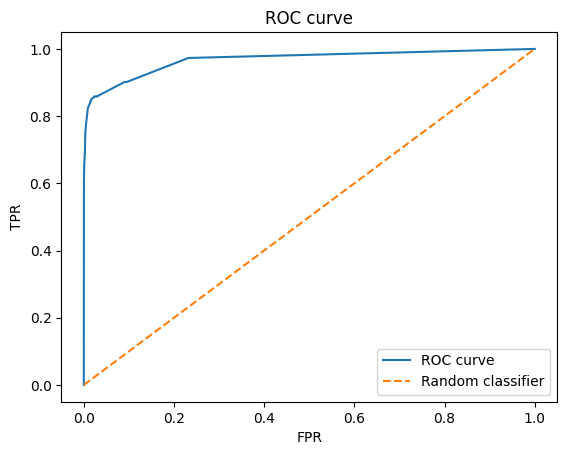

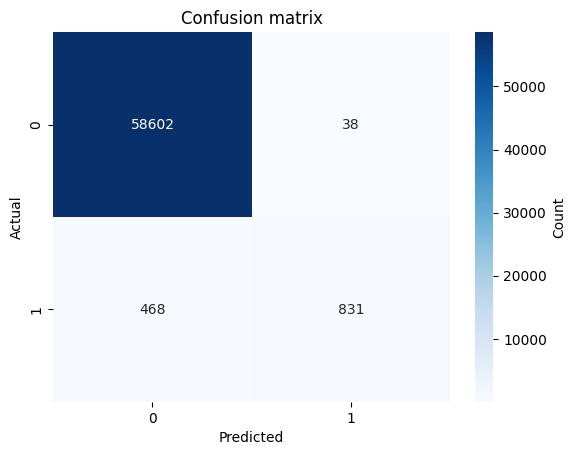

In [154]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Результат приблизительно совпадает с библиотечной моделью.

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [110]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [111]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [112]:
model = model_class(max_depth = max_depth, random_state = random_state)

model.fit(X_train, y_train)

In [113]:
y_pred_class = model.predict(X_test)

In [114]:
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9722 

Precision: 0.956
Recall: 0.6359
F1-Score: 0.7638


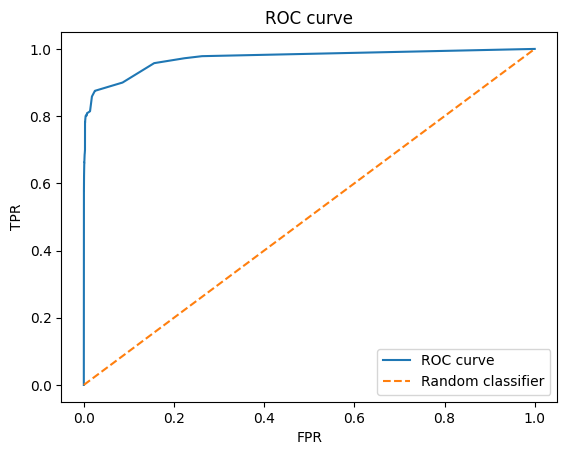

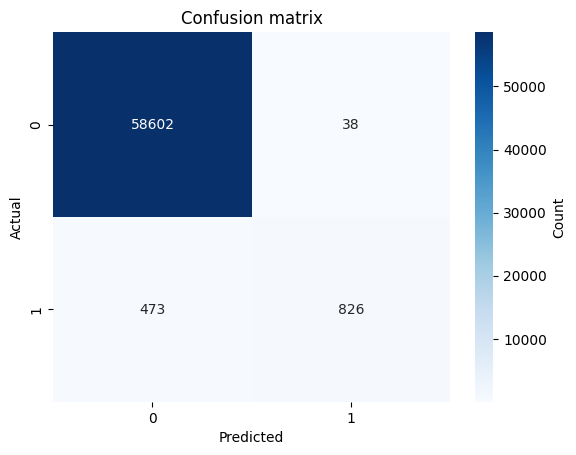

In [115]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Результат незначительно хуже, чем у библиотечной модели (на сотые).

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [139]:
def objective(trial):
    optuna_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),

        'validation_fraction': trial.suggest_categorical('validation_fraction', [0.2]),
        'n_iter_no_change': trial.suggest_categorical('n_iter_no_change', [10]),
        'tol': trial.suggest_categorical('tol', [1e-4]),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-11 20:28:45,855] A new study created in memory with name: no-name-f3a50fb7-1e6f-4be1-9bd9-6d9036313aa7
[I 2025-12-11 20:30:03,136] Trial 0 finished with value: 0.8288467942497255 and parameters: {'n_estimators': 218, 'learning_rate': 0.19014778985134226, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 4, 'subsample': 0.5779972601681014, 'max_features': 'log2', 'loss': 'log_loss', 'validation_fraction': 0.2, 'n_iter_no_change': 10, 'tol': 0.0001, 'random_state': 42}. Best is trial 0 with value: 0.8288467942497255.
[I 2025-12-11 20:33:56,982] Trial 1 finished with value: 0.7915398121295846 and parameters: {'n_estimators': 487, 'learning_rate': 0.1665052838960043, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.6521211214797689, 'max_features': 'sqrt', 'loss': 'log_loss', 'validation_fraction': 0.2, 'n_iter_no_change': 10, 'tol': 0.0001, 'random_state': 42}. Best is trial 0 with value: 0.8288467942497255.
[I 2025-12-11 20:35:29,770] Tr

KeyboardInterrupt: 

In [142]:
best_params = {'n_estimators': 391, 'learning_rate': 0.1629365667231606, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 20, 'subsample': 0.718559510992935, 'max_features': None, 'loss': 'log_loss', 'validation_fraction': 0.2, 'n_iter_no_change': 10, 'tol': 0.0001, 'random_state': 42}

In [143]:
best_model = model_class(**best_params)

In [144]:
best_model.fit(X_train, y_train)

In [145]:
y_pred_class = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

ROC AUC: 0.9789 

Precision: 0.946
Recall: 0.7552
F1-Score: 0.8399


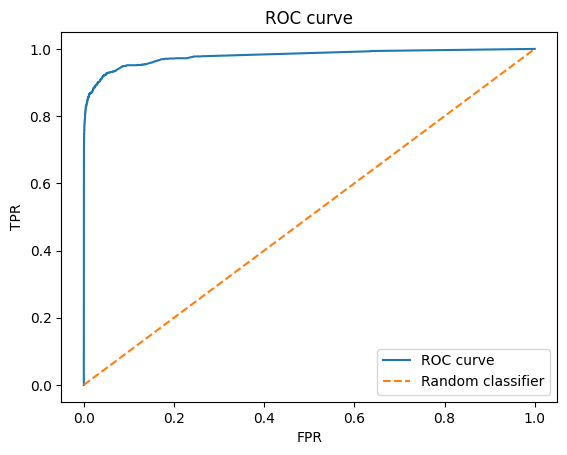

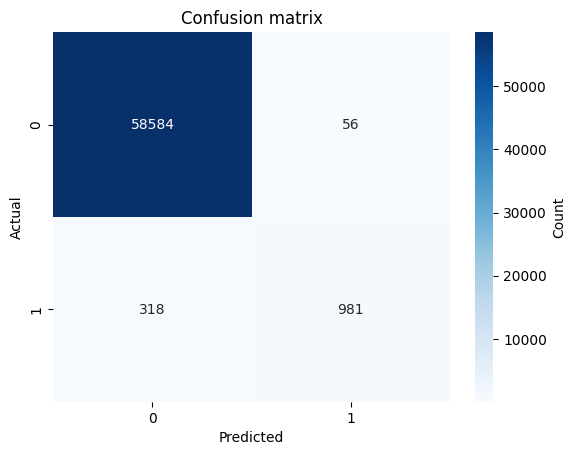

In [146]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Результат идентичен с разностью на сотые-тысячные.

# Выводы

Кастомные реализации случайного леса из деревьев решений показали результаты, идентичные библиотечным моделям. Для оптимизации скорости обучения с учётом реализации деревьев решений в прошлой ЛР, в данной ЛР использовались библиотечные модели деревьев решений, которые объединялись через пользовательский код.

Предобработка данных и подбор гиперпараметров через Optuna с кросс-валидацией показали хороший прирост по метрикам для регресии, хотя по итогу кастомная модель проигрывает библиотечной. На классификации кастомная модель показала идентичный библиотечной результат.